# 00_SIMBA_scRNAseq_tutorial

https://simba-bio.readthedocs.io/en/latest/rna_10xpmbc_all_genes_v1.2.html

In [32]:
import numpy as np

In [1]:
import os
import simba as si
si.__version__

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

'1.2'

In [3]:
workdir = 'result_simba_rnaseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_rnaseq


In [4]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

In [5]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Load example data

In [6]:
adata_CG = si.datasets.rna_10xpmbc3k()

In [7]:
adata_CG

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

# Preprocessing

In [8]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes


In [9]:
si.pp.cal_qc_rna(adata_CG)

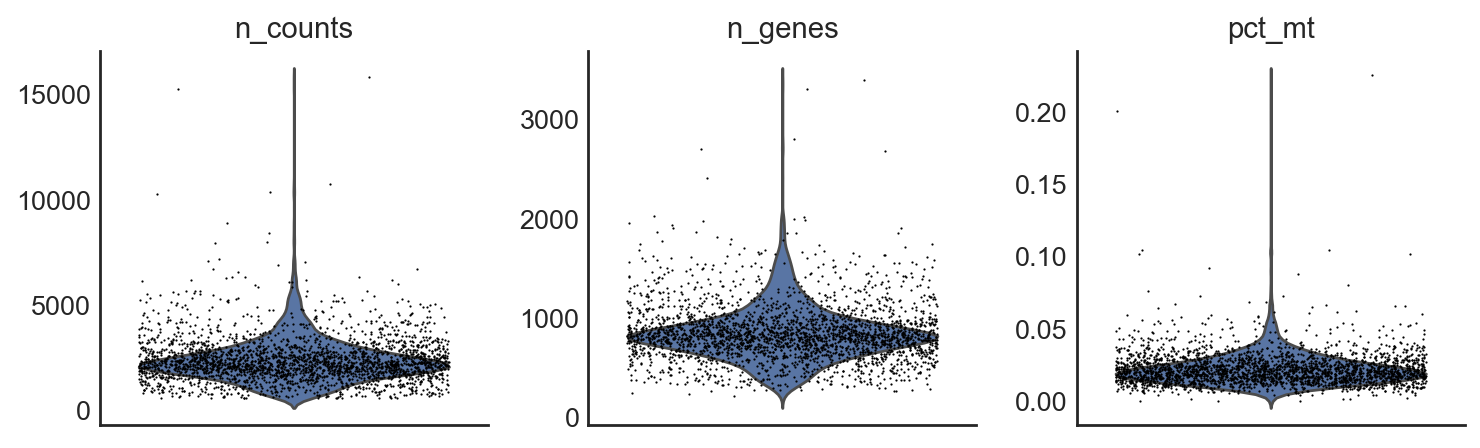

In [10]:
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

Filter out cells if needed:

In [11]:
si.pp.filter_cells_rna(adata_CG,min_n_genes=100)

before filtering: 
2700 cells,  13714 genes
filter cells based on min_n_genes
after filtering out low-quality cells: 
2700 cells,  13714 genes


Normalization and log transform

> The size-factor normalization reduces the technical variation from sequencing depth, while the log transformation minimizes the effects from expression outliers and helps prevent high-abundance genes from dominating downstream analysis due to their higher technical variability - https://www.10xgenomics.com/analysis-guides/single-cell-rna-seq-data-normalization

In [12]:
si.pp.normalize(adata_CG,method='lib_size')
si.pp.log_transform(adata_CG)

Accelerate training procedure by only embedding the highly variable genes. Will lose embedding of the non-variable genes

2000 variable genes are selected.


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/plotting/_plot.py:550: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [plt.text(means[i], variances_norm[i], genes[i],


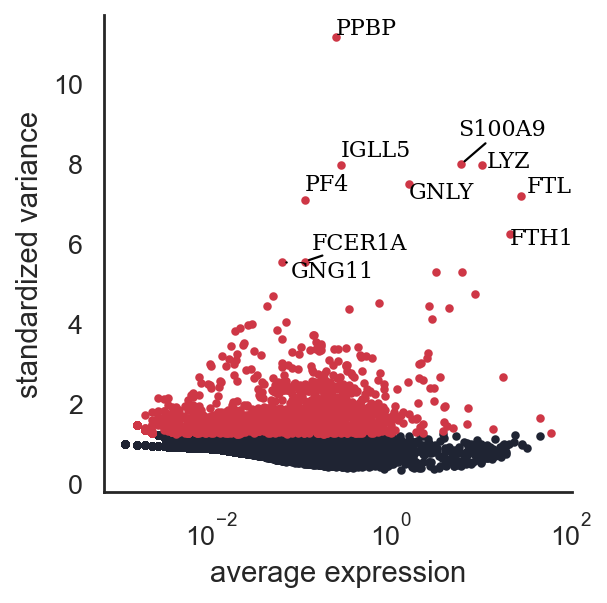

In [13]:
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)

In [16]:
adata_CG.var['highly_variable'].value_counts()

highly_variable
False    11714
True      2000
Name: count, dtype: int64

## Discretize RNA expression

Group non-zero gene expression values into distinct levels while preserving the original distribution. Outputs to `adata.layers['simba']`

How does the discretization work?

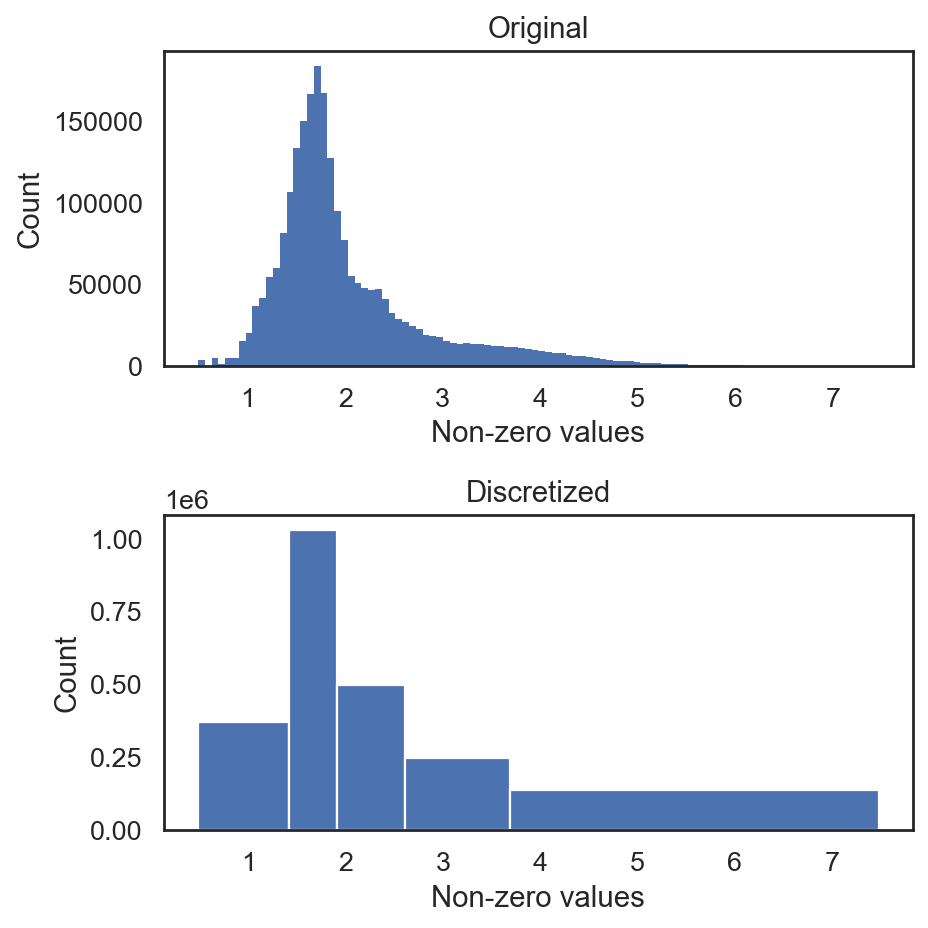

In [17]:
si.tl.discretize(adata_CG,n_bins=5)
si.pl.discretize(adata_CG,kde=False)

In [22]:
adata_CG.obs.head()

,celltype,n_counts,n_genes,pct_genes,pct_mt
AAACATACAACCAC-1,CD4 T,2419.0,779,0.056803,0.030178
AAACATTGAGCTAC-1,B,4903.0,1352,0.098585,0.037936
AAACATTGATCAGC-1,CD4 T,3147.0,1129,0.082325,0.008897
AAACCGTGCTTCCG-1,CD14 Monocytes,2639.0,960,0.070001,0.017431
AAACCGTGTATGCG-1,NK,980.0,521,0.037990,0.012245


In [20]:
display(adata_CG.obs.describe())
display(adata_CG.var.describe())

,n_counts,n_genes,pct_genes,pct_mt
count,2700.000000,2700.000000,2700.000000,2700.000000
mean,2365.376953,845.546667,0.061656,0.022166
std,1093.378784,281.347923,0.020515,0.011667
min,546.000000,212.000000,0.015459,0.000000
25%,1755.750000,690.000000,0.050314,0.015373
50%,2196.000000,816.000000,0.059501,0.020308
75%,2762.250000,952.000000,0.069418,0.026432
max,15818.000000,3400.000000,0.247922,0.225690


,n_counts,n_cells,pct_cells,variances_norm,variances,means
count,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000
mean,465.693298,166.470468,0.061656,0.977878,1.310717,0.172479
std,3538.244141,345.630756,0.128011,0.416399,26.248695,1.310461
min,3.000000,3.000000,0.001111,0.350754,0.001110,0.001111
25%,16.000000,15.000000,0.005556,0.779016,0.006265,0.005926
50%,57.000000,54.000000,0.020000,0.909189,0.023883,0.021111
75%,176.750000,157.000000,0.058148,0.998114,0.100642,0.065463
max,161685.000000,2700.000000,1.000000,11.174310,2007.944938,59.883333


In [33]:
np.unique(adata_CG.layers['simba'].toarray())

array([0, 1, 2, 3, 4, 5])

## Generate a graph for training

Ignores any 0-edges. Above, there are a total of 6 bins (0 through 5), so total number of "relations" is 5. 

In [23]:
si.tl.gen_graph(
    list_CG=[adata_CG],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph0'
)

relation0: source: C, destination: G
#edges: 369270
relation1: source: C, destination: G
#edges: 1029431
relation2: source: C, destination: G
#edges: 498348
relation3: source: C, destination: G
#edges: 247022
relation4: source: C, destination: G
#edges: 138905
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq/pbg/graph0" ...
Finished.


Plot?

## PBG training

- `wd`: weight decay during training (?)

> PBG trains on an input graph by ingesting its list of edges, each identified by its source and target entities and, possibly, a relation type. It outputs a feature vector (embedding) for each entity, trying to place adjacent entities close to each other in the vector space, while pushing unconnected entities apart. Therefore, entities that have a similar distribution of neighbors will end up being nearby. - https://github.com/facebookresearch/PyTorch-BigGraph

Negative sampling: cheaper objective by generating negative samples to compare to positive samples.
> Negative sampling is a technique that modifies the training objective from predicting the entire probability distribution of the vocabulary (as in softmax) to focusing on distinguishing the target word from a few noise (negative) words. Instead of updating the weights for all words in the vocabulary, negative sampling updates the weights for only a small number of words, significantly reducing computation. - https://www.geeksforgeeks.org/negaitve-sampling-using-word2vec/

2 desirable properties of the final embedding:
>First-order similarity: for two entity types with a relation between them, edges with high likelihood should have higher dot product.
>
>Second-order similarity: within a single entity type, entities that have ‘similar contexts’, i.e., a similar distribution of edge probabilities, should have similar embeddings. - https://simba-bio.readthedocs.io/en/latest/Basic%20concepts.html

In [37]:
si.settings.pbg_params

{'entity_path': 'result_simba_rnaseq/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_rnaseq/pbg/graph0/input/edge'],
 'checkpoint_path': 'result_simba_rnaseq/pbg/graph0/model',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.015521,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_nu

In [38]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.015521
Weight decay being used for training is 0.015521
Converting input data ...
[2025-01-07 14:12:23.817754] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-01-07 14:12:23.818209] These files are in: result_simba_rnaseq/pbg/graph0/input/entity, result_simba_rnaseq/pbg/graph0/input/edge
Starting training ...
Finished


mrr: the average of the reciprocal of the ranks of all positives (higher is better, best is 1)
- Want positives to have the highest rank (lowest values, ie 1, 2, etc.). Take the reciprocal --> small values (higher rank) have higher values. 


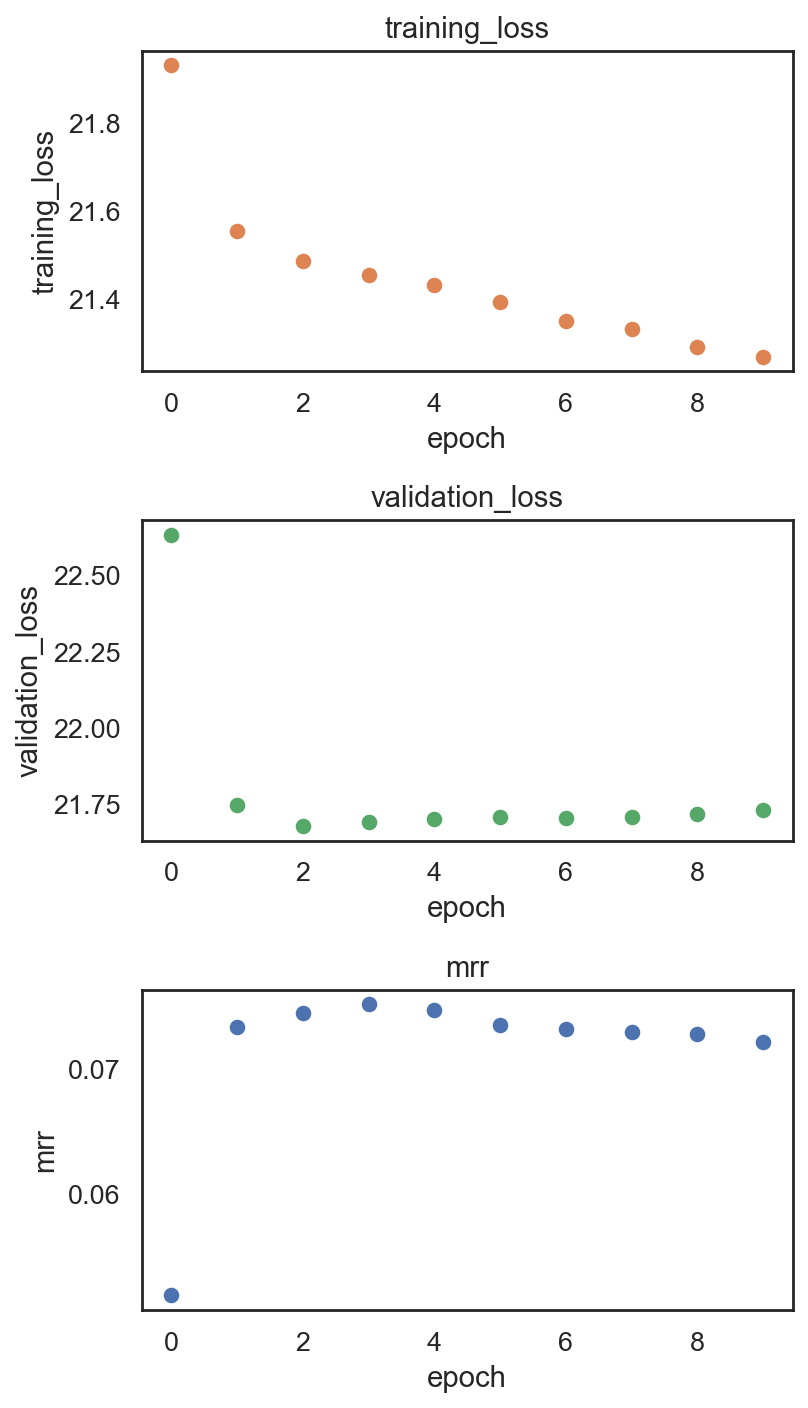

In [39]:
si.pl.pbg_metrics(fig_ncol=1)

Modify parameters for scRNA-seq. Need to change the output path?

In [42]:
# # modify parameters
# dict_config = si.settings.pbg_params.copy()
# # dict_config['wd'] = 0.015521
# dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
# dict_config['workers'] = 12 #The number of CPUs.

# ## start training
# si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output="model2")

## Post-training analysis

In [40]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 13714 × 50,
 'C': AnnData object with n_obs × n_vars = 2700 × 50}

In [43]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [44]:
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

In [45]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


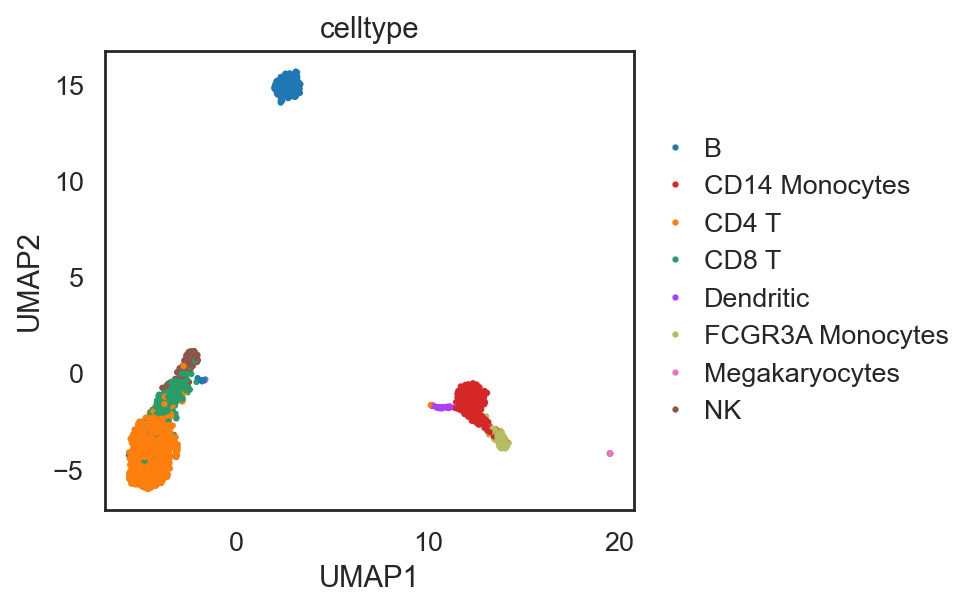

In [46]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C,color=['celltype'],
    dict_palette={'celltype': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

# Visualize embeddings of cells and all genes

Just concatenating the `.obs` table? Difference between ref and query?

In [62]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])
adata_all.obs.head()

Performing softmax transformation for query data 0;


,celltype,id_dataset
CGCACTACAGAATG-1,CD4 T,ref
GCAGCTCTCAATCG-1,CD4 T,ref
GCACCTTGGGGAGT-1,CD14 Monocytes,ref
ATCGCAGAATCTCT-1,FCGR3A Monocytes,ref
ATAGTCCTTGTCGA-1,CD4 T,ref


In [63]:
adata_all.obs.tail()

,celltype,id_dataset
F2R,NaN,query_0
TRAF6,NaN,query_0
CD226,NaN,query_0
ATM,NaN,query_0
ASB1,NaN,query_0


In [64]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.head()

,celltype,id_dataset,entity_anno
CGCACTACAGAATG-1,CD4 T,ref,CD4 T
GCAGCTCTCAATCG-1,CD4 T,ref,CD4 T
GCACCTTGGGGAGT-1,CD14 Monocytes,ref,CD14 Monocytes
ATCGCAGAATCTCT-1,FCGR3A Monocytes,ref,FCGR3A Monocytes
ATAGTCCTTGTCGA-1,CD4 T,ref,CD4 T


In [65]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"

Reverse order so genes are plotted first.

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


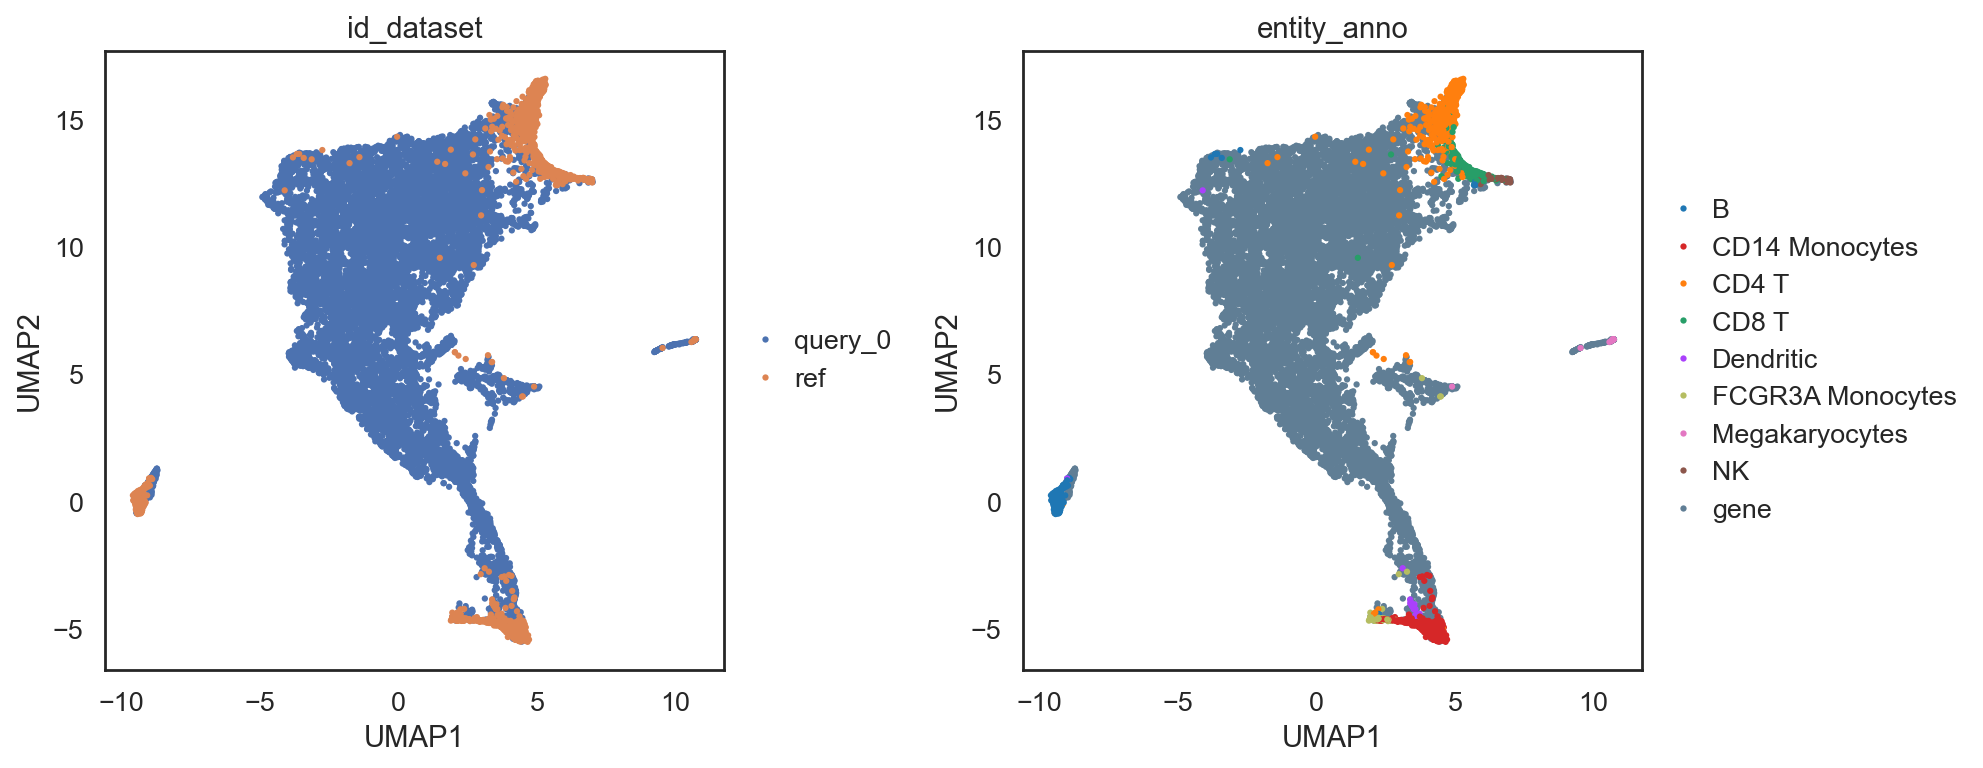

In [67]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)
si.pl.umap(adata_all[::-1,],color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


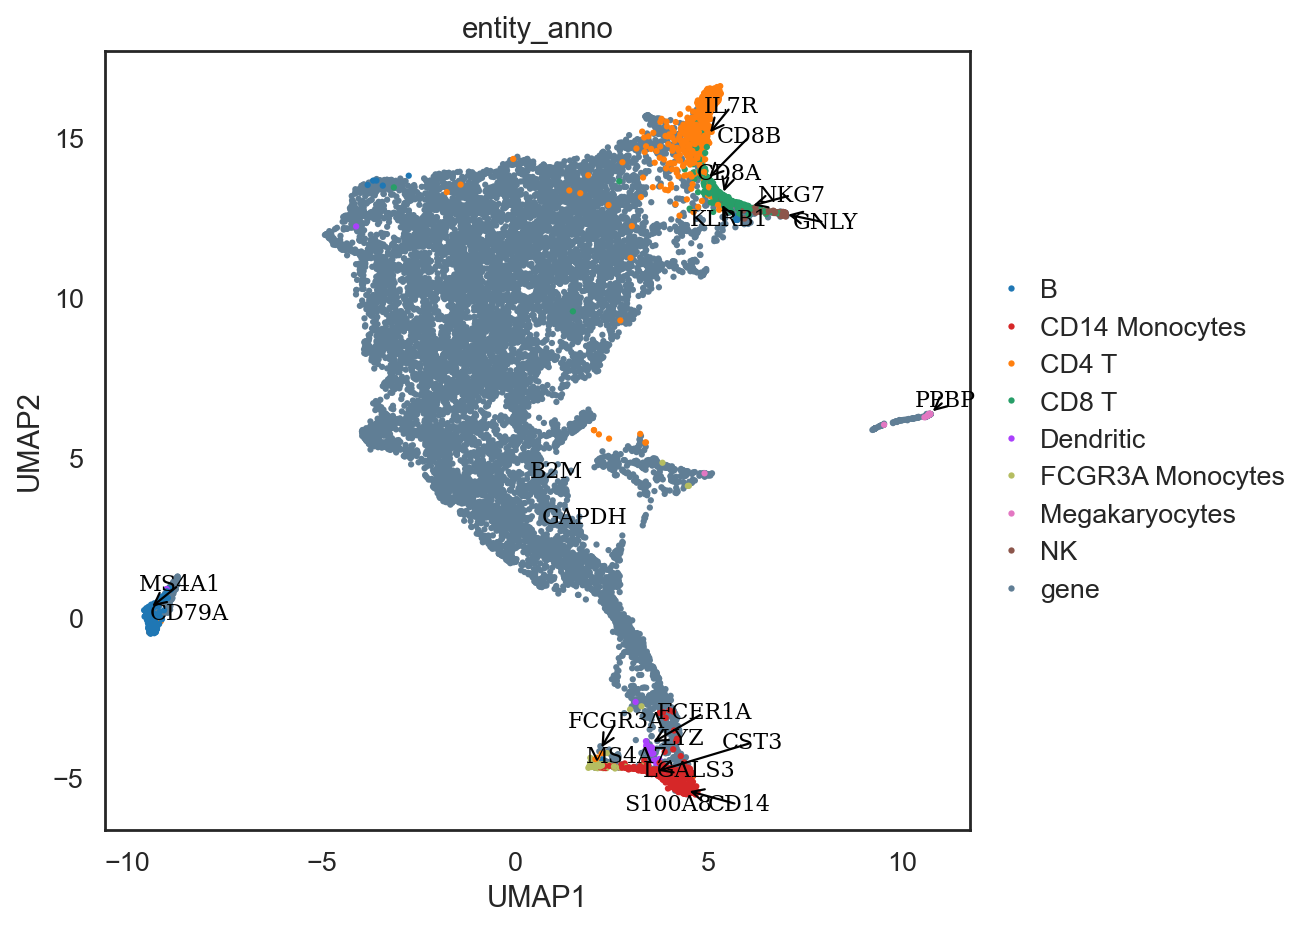

In [68]:
# highlight some marker genes in the co-embedding space
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
si.pl.umap(adata_all[::-1,],color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           texts=marker_genes + ['GAPDH', 'B2M'],
           show_texts=True,
           fig_size=(8,6))

Visualize only variable genes

3000 variable genes are selected.


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


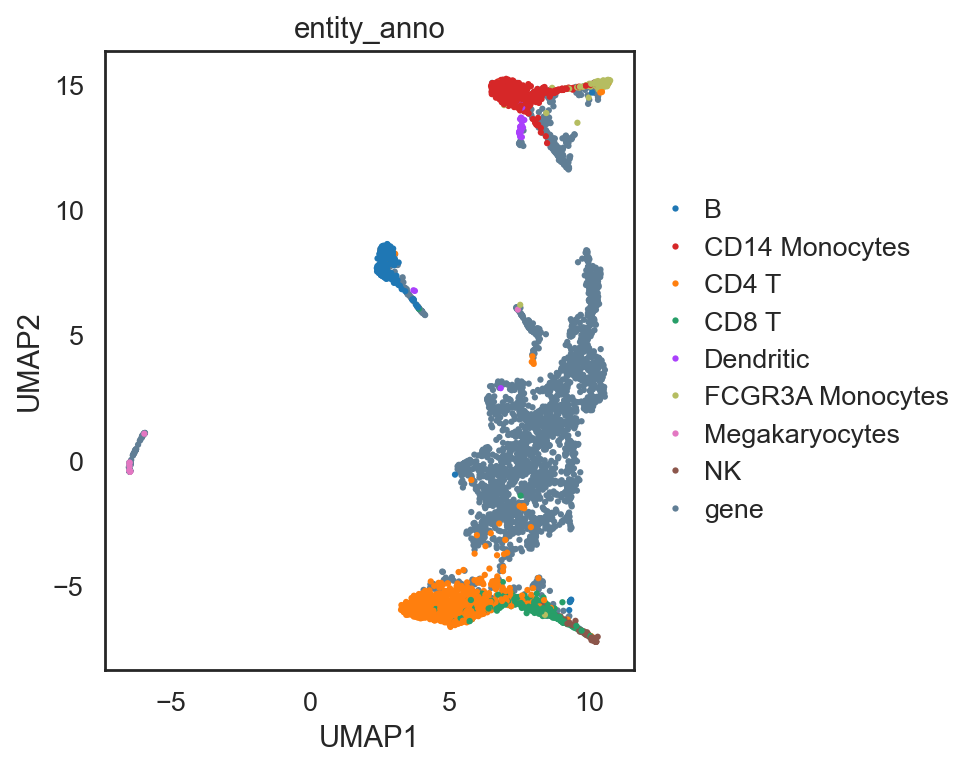

In [69]:
# obtain variable genes
si.pp.select_variable_genes(adata_CG, n_top_genes=3000)
var_genes = adata_CG.var_names[adata_CG.var['highly_variable']].tolist()
# obtain SIMBA embeddings of cells and variable genes
adata_all2 = adata_all[list(adata_C.obs_names) + var_genes,].copy()
# visualize them using UMAP
si.tl.umap(adata_all2,n_neighbors=15,n_components=2)
si.pl.umap(adata_all2[::-1],color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))


## Clustering-free marker discovery

- max: a higher value indicates higher cell-type specificity (just dot product?)

- gini: a higher value indicates higher cell-type specificity. Originally made to describe inequality (some distribution of fixed quantity?)

- std: a higher value indicates higher cell-type specificity

- entropy: a lower value indicates higher cell-type specificity

Below: "distribution" of the dot product/softmax of each gene across all the cells? I.e. if there is only one cell whose embedding is close to gene A, then the gini index will be 100% (most "inequality"). If a gene is mostly uniformly distance from all the cells, then low gini index/low infromation (high entropy)

In [70]:
adata_cmp = si.tl.compare_entities(adata_ref=adata_C, adata_query=adata_G)
adata_cmp

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype'
    var: 'max', 'std', 'gini', 'entropy'
    layers: 'norm', 'softmax'

In [74]:
# genes can be ranked based on either one or multiple metrics
adata_cmp.var.head()

,max,std,gini,entropy
LPP-AS2,0.446424,0.181592,0.103499,7.882719
NRGN,1.979530,0.878074,0.634020,6.569058
INTS1,0.314577,0.115818,0.065967,7.894027
CDC23,0.502322,0.203844,0.114781,7.879988
CHMP2B,0.813295,0.273188,0.156138,7.858799


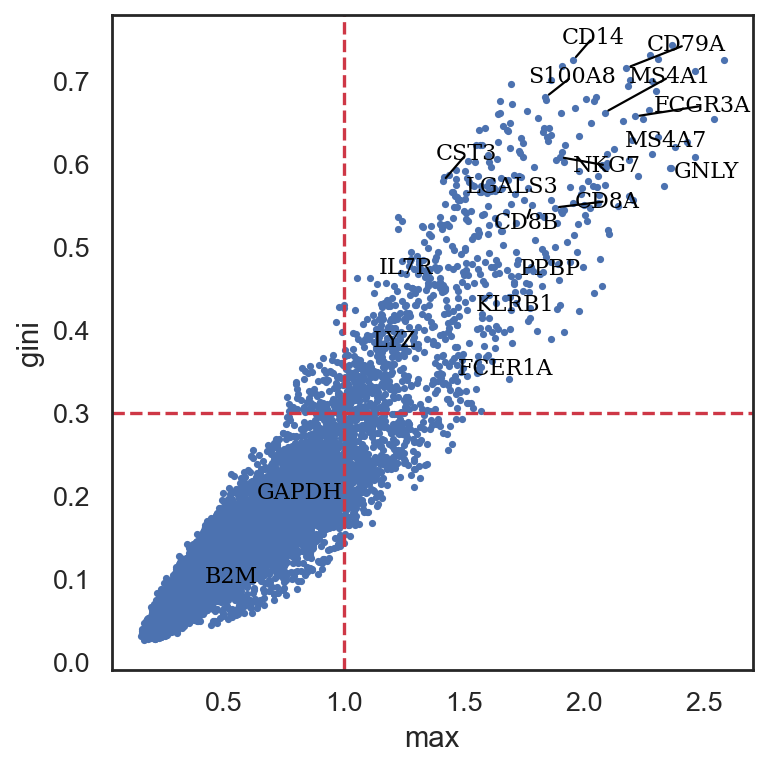

In [75]:
# SIMBA metrics can be visualized using the following function:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_x=1.,
                     cutoff_y=0.3,
                     save_fig=False)

## SIMBA barcode plot

Sort cells by "distance"/dot product to the gene. Color bars by the cell type to illustrate cell type specificity of the gene's embedding

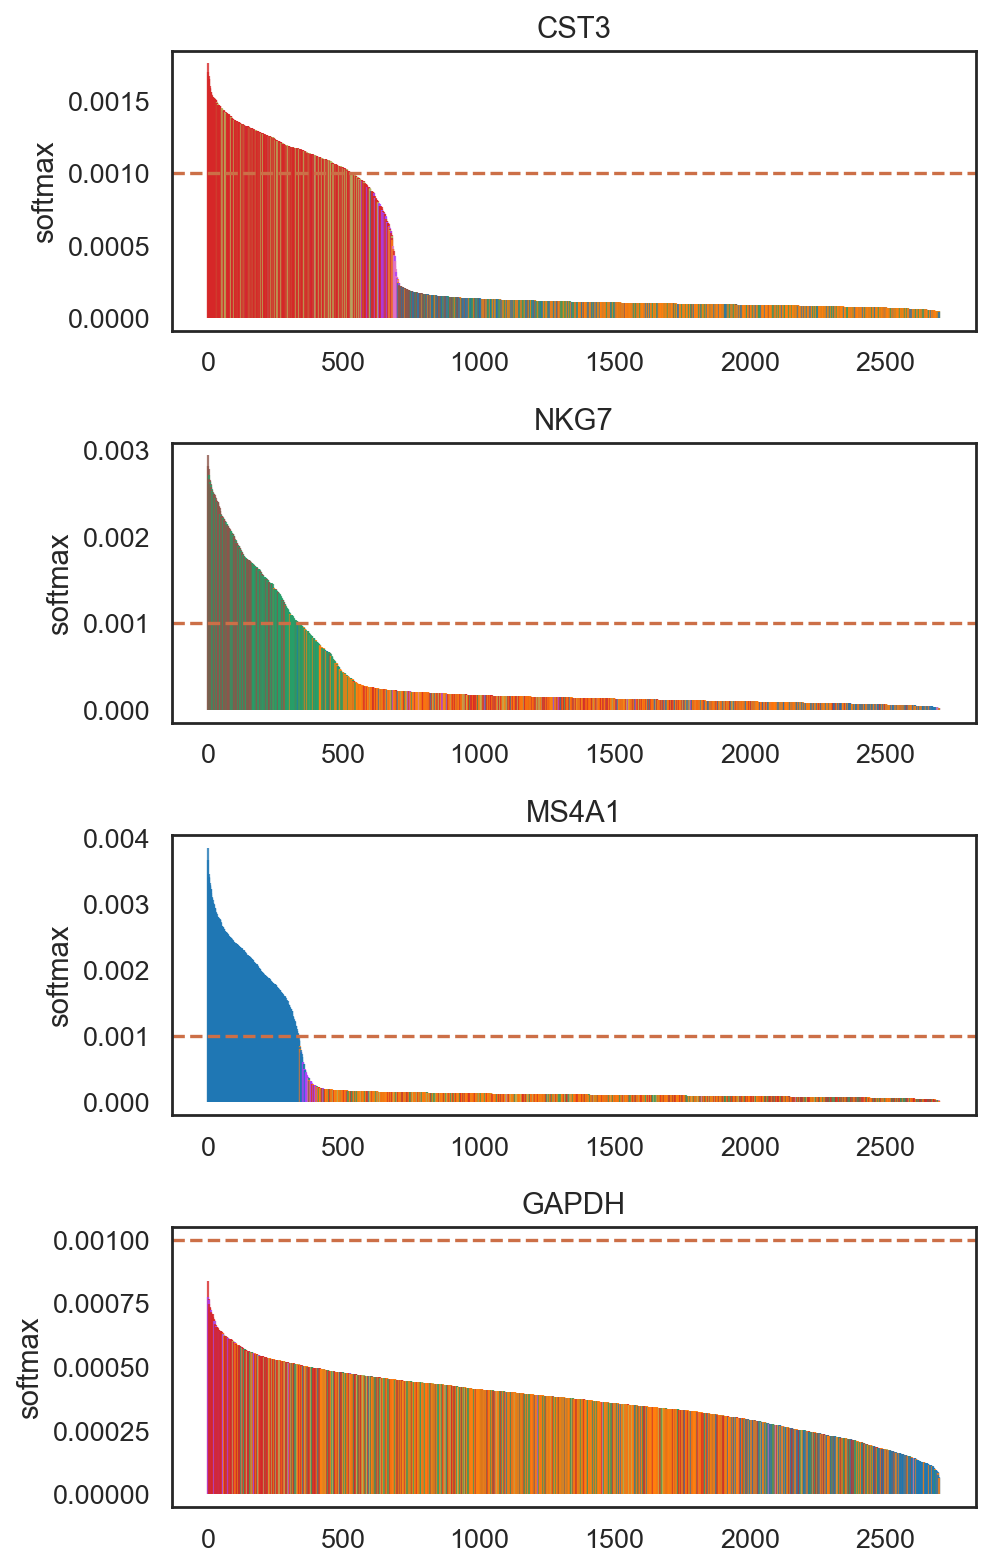

In [76]:
# add annoations of cells
adata_cmp.obs['celltype'] = adata_CG.obs.loc[adata_cmp.obs_names,'celltype']
list_genes = ['CST3', 'NKG7', 'MS4A1', 'GAPDH']
si.pl.entity_barcode(adata_cmp,
                     layer='softmax',
                     entities=list_genes,
                     anno_ref='celltype',
                     show_cutoff=True,
                     cutoff=0.001,
                     palette=palette_celltype,
                     fig_size=(6, 2.5),
                     save_fig=False)

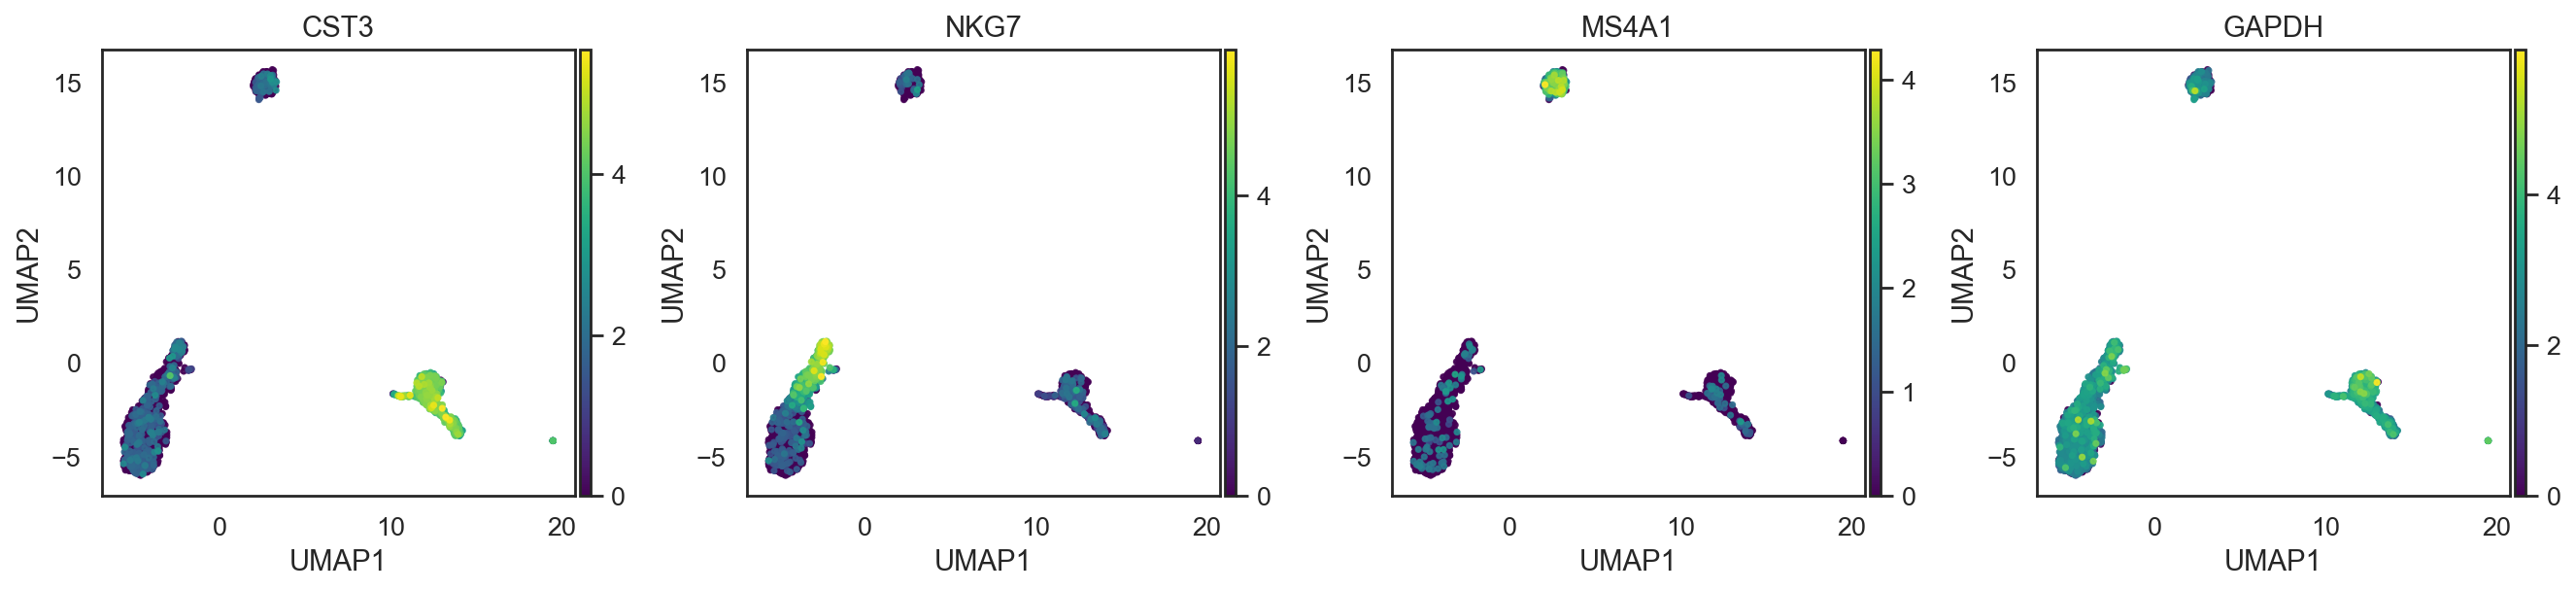

In [77]:
# The same list of genes can also be visualized on UMAP to confirm their cell type specificity
adata_CG.obsm['X_umap'] = adata_C[adata_CG.obs_names,].obsm['X_umap'].copy()
si.pl.umap(adata_CG,
           color=['CST3', 'NKG7', 'MS4A1', 'GAPDH'],
           drawing_order='sorted',
           size=5,
           alpha=0.9,
           fig_ncol=4,
           fig_size=(4,4),
           save_fig=False)

## Queries of entities in SIMBA space

Perform queries by looking at an entity's neighbors.

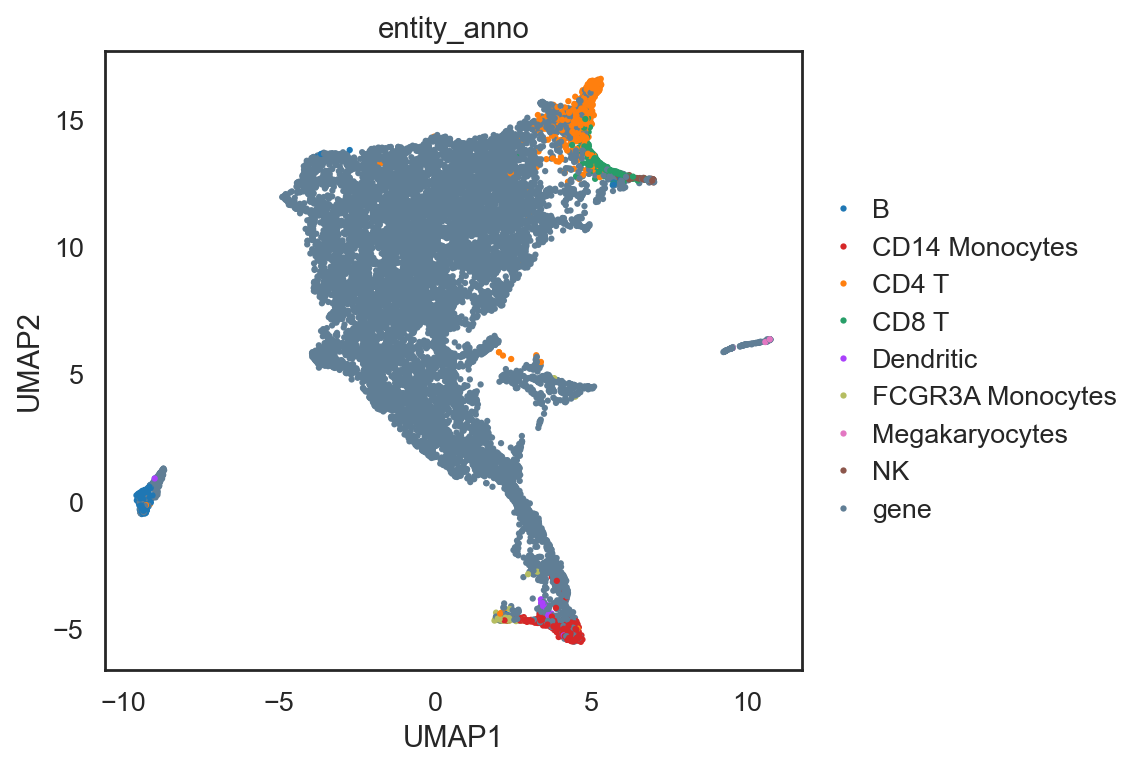

In [78]:
# First, we visualize the SIMBA co-embedding space, which serves as a database of entities including both cells and features (e.g., genes) and also where queries of entities will be performed
si.pl.umap(adata_all[::-1,],
           color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='random',
           show_texts=False,
           fig_size=(7,5))

Why pin relative to the UMAP?

In [79]:
# find neighbor genes around the location [6, 16] on UMAP
query_result = si.tl.query(adata_all,
                           pin=[6,16],
                           obsm='X_umap',
                           use_radius=True,r=2,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(98, 5)


,celltype,id_dataset,entity_anno,distance,query
PIK3IP1,NaN,query_0,gene,0.879954,0
LDLRAP1,NaN,query_0,gene,0.908634,0
TRABD2A,NaN,query_0,gene,0.918810,0
EPHX2,NaN,query_0,gene,0.927814,0
CCR7,NaN,query_0,gene,0.943774,0


In [84]:
adata_all

AnnData object with n_obs × n_vars = 16414 × 50
    obs: 'celltype', 'id_dataset', 'entity_anno'
    uns: 'color', 'query'
    obsm: 'X_umap'

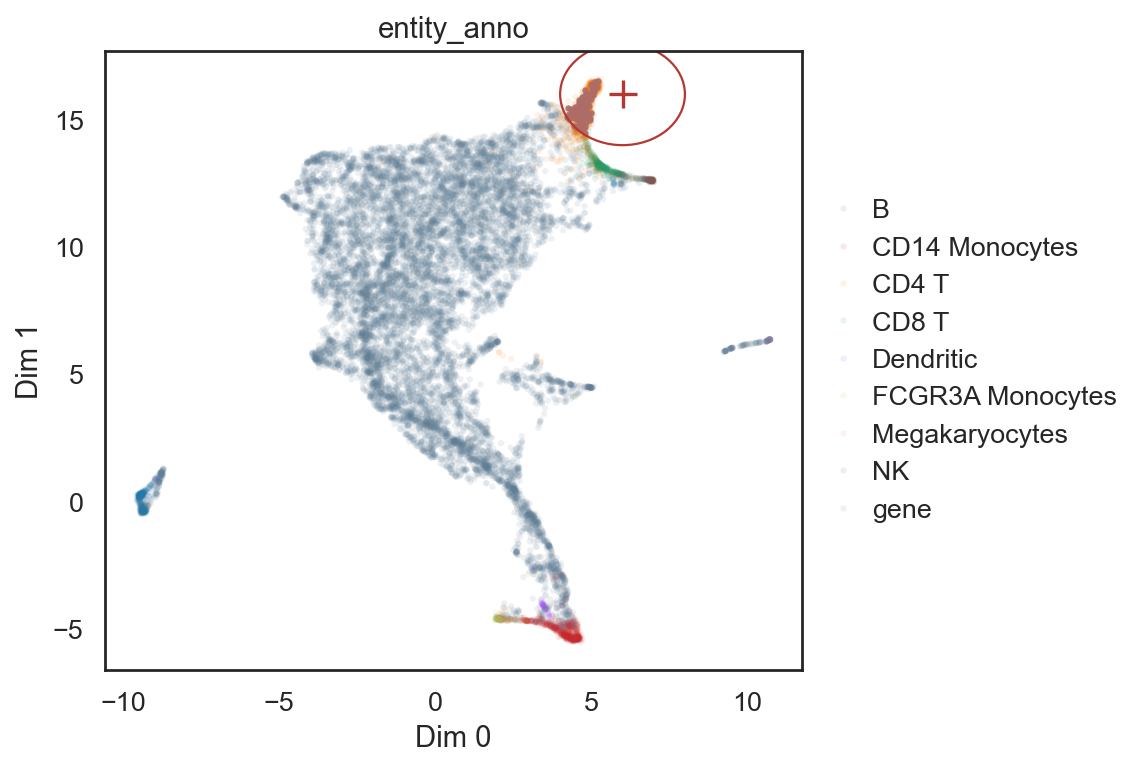

In [80]:
# show locations of pin point and its neighbor genes
si.pl.query(adata_all,
            show_texts=False,
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [85]:
# find top 50 neighbor genes around cell "ACTCAGGATTCGTT-1" (CD14 Monocytes) in SIMBA space
query_result = si.tl.query(adata_all,
                           entity=['ACTCAGGATTCGTT-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(50, 5)


,celltype,id_dataset,entity_anno,distance,query
NUP214,NaN,query_0,gene,1.486038,ACTCAGGATTCGTT-1
NRG1,NaN,query_0,gene,1.487446,ACTCAGGATTCGTT-1
CSF3R,NaN,query_0,gene,1.498962,ACTCAGGATTCGTT-1
S100A8,NaN,query_0,gene,1.502443,ACTCAGGATTCGTT-1
S100A12,NaN,query_0,gene,1.502835,ACTCAGGATTCGTT-1


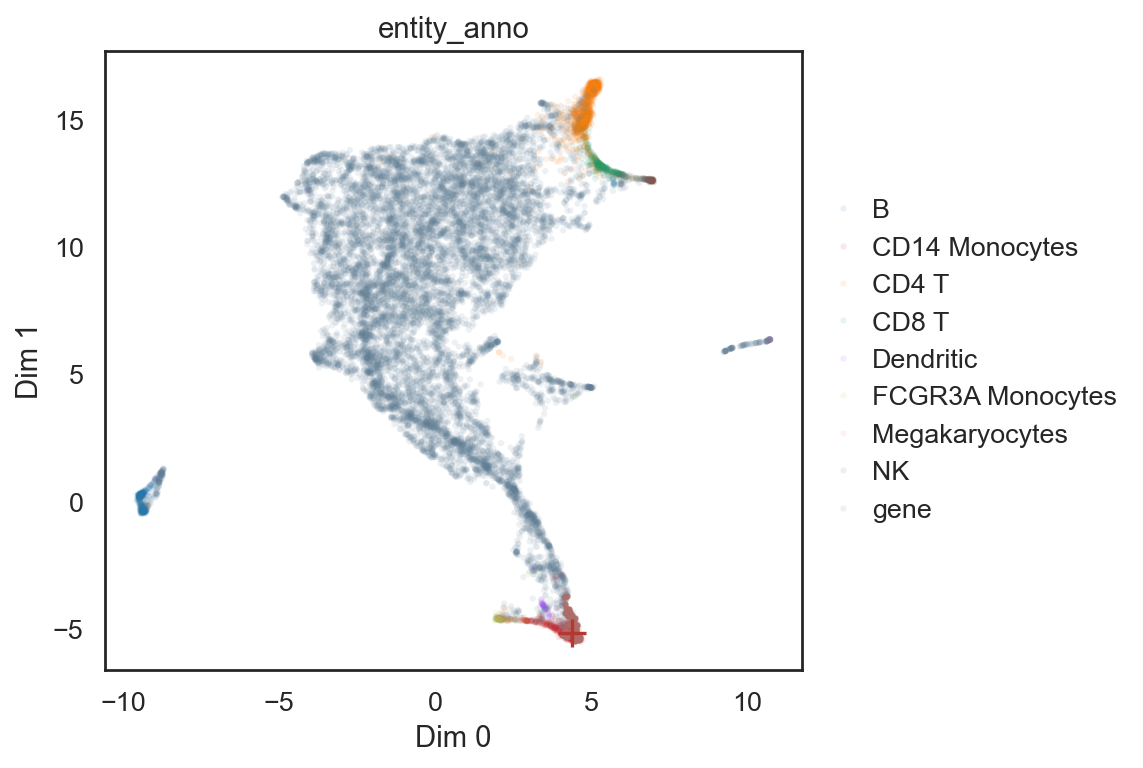

In [87]:
# show locations of entity and its neighbor genes
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [90]:
adata_all

AnnData object with n_obs × n_vars = 16414 × 50
    obs: 'celltype', 'id_dataset', 'entity_anno'
    uns: 'color', 'query'
    obsm: 'X_umap'

In [88]:
# find top 50 neighbor genes for multiples cells in SIMBA space
query_result = si.tl.query(adata_all,entity=['GATGCCCTCTCATT-1', 'CTGAAGTGGCTATG-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'],
                           )
print(query_result.shape)
query_result.head()

(100, 5)


,celltype,id_dataset,entity_anno,distance,query
MAL,NaN,query_0,gene,0.991037,GATGCCCTCTCATT-1
APBA2,NaN,query_0,gene,1.002578,GATGCCCTCTCATT-1
LGALS3BP,NaN,query_0,gene,1.003213,GATGCCCTCTCATT-1
TSHZ2,NaN,query_0,gene,1.007216,GATGCCCTCTCATT-1
SUSD3,NaN,query_0,gene,1.007708,GATGCCCTCTCATT-1


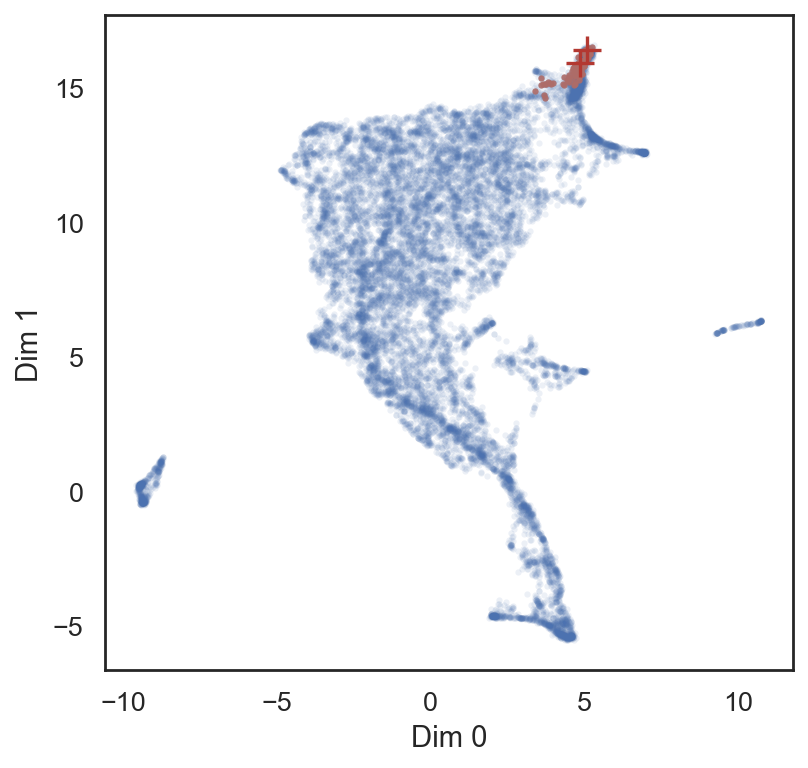

In [91]:
# show locations of entities and their neighbor genes
si.pl.query(adata_all,
            obsm='X_umap',
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(5,5))

In [92]:
# find neighbor entities (both cells and genes) of a given gene on UMAP
query_result = si.tl.query(adata_all,
                           entity=['CD79A'],
                           obsm='X_umap',
                           use_radius=False,
                           k=50
                           )
print(query_result.shape)
query_result.iloc[:10,]

(50, 5)


,celltype,id_dataset,entity_anno,distance,query
CD79A,NaN,query_0,gene,0.000000,CD79A
SPIB,NaN,query_0,gene,0.013807,CD79A
AGGGTGGACAGTCA-1,B,ref,B,0.019429,CD79A
TTGAACCTCCTTGC-1,B,ref,B,0.021613,CD79A
TACGTACTCCCGTT-1,B,ref,B,0.022110,CD79A
CCGTACACAGCGTT-1,B,ref,B,0.025084,CD79A
AGGTGTTGGTTACG-1,B,ref,B,0.030840,CD79A
CAGATCGAATGTCG-1,B,ref,B,0.034585,CD79A
TATACCACCTGATG-1,B,ref,B,0.036164,CD79A
CGCGAGACAGGTCT-1,B,ref,B,0.036535,CD79A


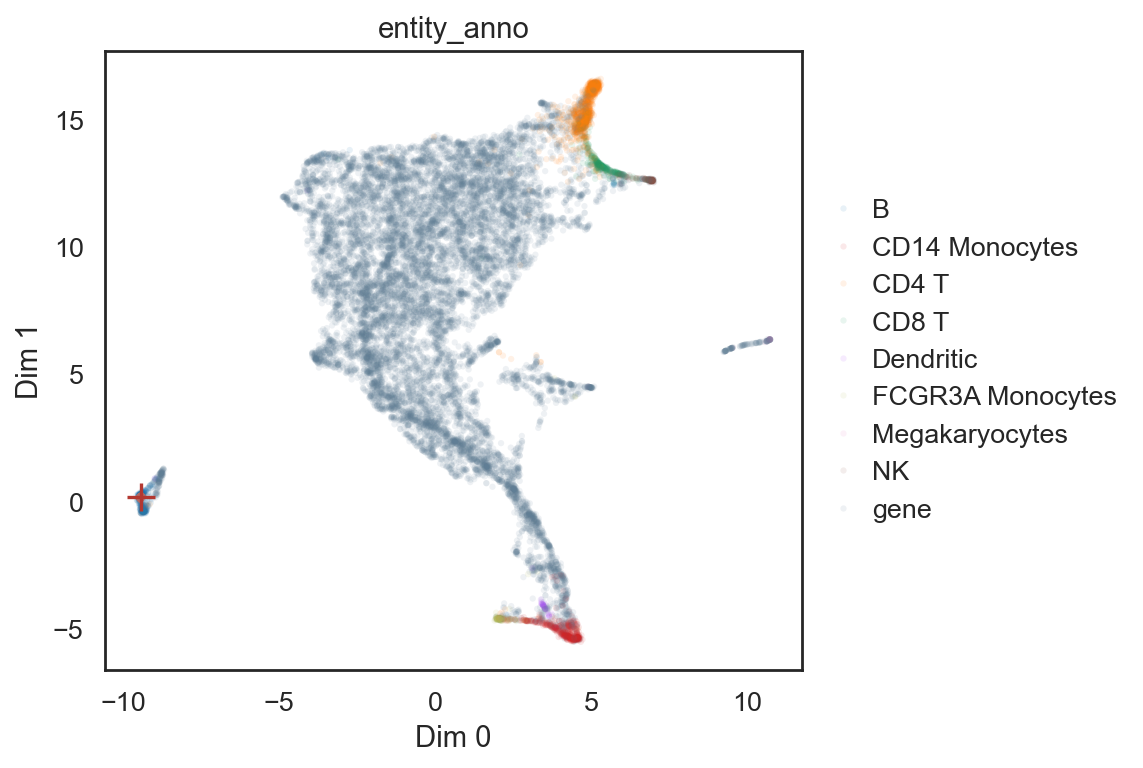

In [93]:
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))


# Save data

In [94]:
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp.write(os.path.join(workdir, 'adata_cmp.h5ad'))